### RFC

### import modules and configure notebook

In [7]:
import pandas as pd
import numpy as np
import swifter
import seaborn as sns
import matplotlib.pyplot
import pickle

pd.set_option('max.rows', None)
pd.set_option('max.columns', None)

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV 
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

### Load variables stored by data_preproccessing notebook

In [8]:
%store -r train_data_formodel
%store -r test_data
%store -r my_data
%store -r uniques
%store -r best_feats


In [9]:
save_plots = False
random_seed_state = 42
classify_bedrock_only = False
pickle_model = False
pickle_model_name = 'grouped'

### I label encode the class column again because just bedrock is being classified and when class was label encoded in data reproccessing script label encoding was done for both bedrock sites and superficial regions

In [10]:
if classify_bedrock_only:
    train_data_formodel['class'], uniques = pd.factorize(train_data_formodel['class'])
    train_data_formodel = train_data_formodel[train_data_formodel['Geology']=='Bedrock']

In [11]:
train_data_formodel.columns.values[9:-1]

array(['Li7', 'Be9', 'B11', 'Mg24', 'Al27', 'Si28', 'P31', 'S33', 'K39',
       'Ca42', 'Sc45', 'Ti47', 'V51', 'Cr52', 'Mn55', 'Fe56', 'Co59',
       'Ni60', 'Cu63', 'Zn68', 'Ga69', 'Ge72', 'As75', 'Rb85', 'Sr88',
       'Y89', 'Zr90', 'Nb93', 'Mo95', 'Cd111', 'In115', 'Sn118', 'Cs133',
       'Ba137', 'La139', 'Ce140', 'Pr141', 'Nd146', 'Sm147', 'Eu153',
       'Gd157', 'Tb159', 'Dy163', 'Ho165', 'Er166', 'Tm169', 'Yb172',
       'Lu175', 'Hf178', 'Ta181', 'Pb208', 'Th232', 'U238'], dtype=object)

In [12]:
train_data_formodel.head()

,Analysis,Geology,Province,Region,Site,SubSite,Formation,Band,Nodule,Li7,Be9,B11,Mg24,Al27,Si28,P31,S33,K39,Ca42,Sc45,Ti47,V51,Cr52,Mn55,Fe56,Co59,Ni60,Cu63,Zn68,Ga69,Ge72,As75,Rb85,Sr88,Y89,Zr90,Nb93,Mo95,Cd111,In115,Sn118,Cs133,Ba137,La139,Ce140,Pr141,Nd146,Sm147,Eu153,Gd157,Tb159,Dy163,Ho165,Er166,Tm169,Yb172,Lu175,Hf178,Ta181,Pb208,Th232,U238,class
0,10_FH1_1_1,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_1,15.63,0.12,48.36,154.63,943.71,464944.18,50.28,538.57,455.94,712.39,0.42,15.58,0.27,3.30,0.69,8.46,0.05,0.80,1.62,10.82,0.25,1.22,0.16,0.43,12.94,0.88,1.51,0.09,0.05,0.02,0.00,0.05,0.01,6.54,0.84,0.95,0.23,0.87,0.16,0.04,0.16,0.02,0.11,0.03,0.06,0.01,0.02,0.00,0.04,0.01,0.24,0.07,0.05,0
1,11_FH1_1_1,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_1,11.50,0.09,44.77,22.42,1077.11,465010.94,70.91,438.20,387.82,515.24,0.44,18.47,0.29,3.45,1.01,11.59,0.11,0.36,0.53,8.93,0.34,0.85,0.10,0.45,13.22,0.95,1.74,0.07,0.01,0.02,0.00,0.04,0.02,8.04,0.92,1.01,0.23,0.98,0.18,0.04,0.18,0.02,0.13,0.03,0.06,0.01,0.04,0.01,0.05,0.00,0.07,0.08,0.04,0
2,12_FH1_1_1,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_1,20.05,0.06,44.88,42.70,620.21,465295.41,104.47,372.66,363.71,957.89,0.76,19.89,0.55,3.25,1.21,87.99,0.21,1.68,1.53,11.98,0.25,1.71,0.13,0.43,8.52,0.87,0.93,0.10,0.02,0.02,0.00,0.05,0.01,3.13,0.90,1.08,0.26,0.84,0.15,0.04,0.19,0.02,0.14,0.02,0.07,0.01,0.06,0.00,0.02,0.01,0.46,0.05,0.05,0
3,13_FH1_1_2,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_2,11.16,0.73,47.06,162.42,1143.19,465099.89,56367.93,1075.89,547.55,2174.30,0.43,42.30,0.67,152.42,4.84,145.34,0.30,2.45,5.02,17.15,0.35,2.13,0.84,0.76,13.16,0.97,2.00,0.10,0.29,0.18,0.01,0.78,0.04,8.74,0.93,0.95,0.21,0.75,0.13,0.04,0.25,0.02,0.09,0.03,0.05,0.00,0.03,0.00,0.08,0.00,0.64,0.05,0.03,0
4,14_FH1_1_2,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_2,17.71,0.32,48.26,33.52,547.22,465027.11,44.44,464.78,278.25,1551.63,0.71,11.18,0.27,2.56,1.73,25.38,0.05,0.80,0.55,9.80,0.41,1.41,0.12,0.28,9.90,0.90,0.90,0.08,0.04,0.10,0.00,0.09,0.01,2.74,0.97,1.09,0.27,1.00,0.17,0.04,0.19,0.02,0.15,0.03,0.05,0.01,0.05,0.01,0.02,0.01,0.59,0.06,0.09,0


In [13]:
y = np.array(train_data_formodel['class'])

In [14]:
train_data_feats = train_data_formodel[train_data_formodel.columns.values[9:-1]]

In [15]:
train_data_feats.shape

(1243, 53)

In [16]:

my_scaler = StandardScaler()

### Turn feature data and class to be predicited into numpy arrays

In [17]:
X = np.array(my_scaler.fit_transform(train_data_feats))

In [18]:
print(X.shape)
print(y.shape)

(1243, 53)
(1243,)


In [19]:

mlp = MLPClassifier(solver = 'lbfgs')
parameter_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100, 50, 50), (50,100,100), (50,50,50,50)],
    'activation': ['tanh', 'relu'],
    'alpha': 10.0 ** -np.arange(1, 7),
    'learning_rate': ['constant','adaptive'],
}

In [23]:

%%time
clf = GridSearchCV(mlp, param_grid=parameter_grid, n_jobs=-1, error_score='f1', cv = 3, verbose=2)
clf.fit(X, y)

Fitting 3 folds for each of 120 candidates, totalling 360 fits
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=constant 
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=constant 
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=constant 
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, total=   4.4s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, total=   4.5s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, total=   4.7s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=c

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   59.3s


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, total=   5.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, total=   5.1s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, total=   4.6s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, total=   7.6s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, total=   7.8s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive 
[CV]  ac

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.8min


[CV]  activation=tanh, alpha=1e-06, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, total=   2.1s
[CV] activation=tanh, alpha=1e-06, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive 
[CV]  activation=tanh, alpha=1e-06, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, total=   3.2s
[CV] activation=tanh, alpha=1e-06, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive 
[CV]  activation=tanh, alpha=1e-06, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, total=   2.4s
[CV] activation=tanh, alpha=1e-06, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive 
[CV]  activation=tanh, alpha=1e-06, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, total=   4.2s
[CV] activation=tanh, alpha=1e-06, hidden_layer_sizes=(100, 50, 50), learning_rate=constant 
[CV]  activation=tanh, alpha=1e-06, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, total=   5.0s
[CV] activation=tanh, alpha=1e-06, hidden_layer_sizes=(100, 50, 50), learning_rate=consta

[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  6.9min finished


CPU times: user 7.37 s, sys: 787 ms, total: 8.15 s
Wall time: 6min 57s


In [24]:
clf.best_params_
print(''{'activation': 'tanh',
 'alpha': 0.1,
 'hidden_layer_sizes': (100, 50, 50),
 'learning_rate': 'constant'}')

{'activation': 'tanh',
 'alpha': 0.1,
 'hidden_layer_sizes': (100, 50, 50),
 'learning_rate': 'constant'}

### Carry out 10-f0ld stratified cross validation, class f1 scores and macro f1 scores with weighted averages are calculated

In [27]:
%%time
mlp = MLPClassifier(hidden_layer_sizes=(100, 50, 50), activation = 'tanh', max_iter=3000, alpha=0.1,
                    solver='lbfgs', verbose=3,  random_state=42,tol=0.0000000001, learning_rate  ='constant')
skf = StratifiedKFold(n_splits=10, random_state=random_seed_state)
skf.get_n_splits(X, y)
class_f1_scores = []
macro_f1_scores = []
accuracy_scores = []
feat_imp =[]
f1_dict = {}
feat_imp_dict = {}
count = 0
for train_index, test_index in skf.split(X, y):
    count = count + 1
    print('making model:')
    key = 'round' + str(count)
    print(count)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    class_f1_scores = f1_score(y_test, y_pred, average = None)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    macro_f1_scores.append(f1_score(y_test, y_pred, average = 'weighted'))
    f1_dict[key] = class_f1_scores 
    

making model:
1
making model:
2
making model:
3


/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
4
making model:
5


/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
6
making model:
7


/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
8


/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
9


/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
10
CPU times: user 12min 25s, sys: 21.4 s, total: 12min 46s
Wall time: 6min 24s


/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
f1_df = pd.DataFrame(data = f1_dict)


In [29]:
for key in f1_dict:
    print(len(f1_dict[key]))

24
24
24
24
24
24
24
24
24
24


### Below are the encodings for the class variable

In [30]:
print(train_data_formodel['class'].unique())
print(list(uniques))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
['FH', 'ER', 'WW', 'TC', 'BC_CS', 'KQ', 'AR', 'SL', 'FG', 'WB_BX', 'PF', 'BM', 'WH', 'SQ_BP', 'WN', 'BH', 'PH', 'LB', 'AB', 'LV', 'SV_SE', 'BA', 'WA', 'MM']


In [31]:
f1_df_final = pd.concat([f1_df, pd.Series(uniques)], axis = 1)

In [32]:
f1_df_final.rename(columns={0:'class'}, inplace=True)
f1_df_final.set_index('class', drop = True, inplace = True)

### Boxplot showing the distribution of class f1 scores from 10 models

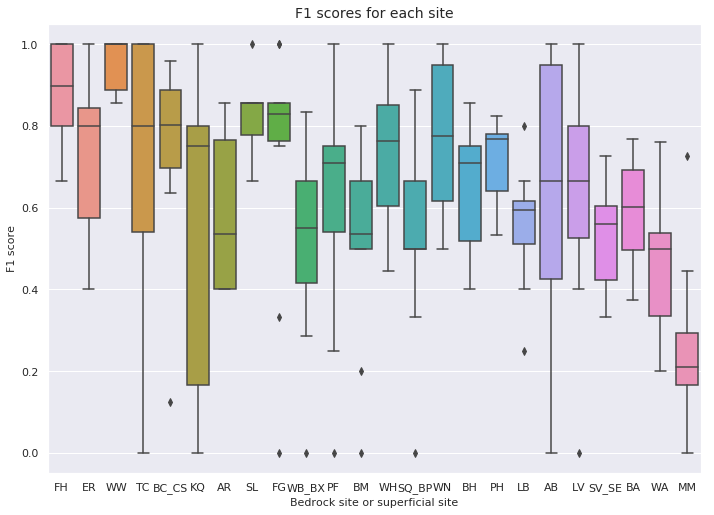

In [33]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.boxplot(data = f1_df_final.T)
plot.set_title('F1 scores for each site', fontdict={'fontsize': 14})
plot.set_ylabel('F1 score', fontdict={'fontsize': 11})
plot.set_xlabel("Bedrock site or superficial site", fontdict={'fontsize': 11})

if save_plots == True:
    fig = plot.get_figure()
    fig.savefig('output/site_specific_f1_scores.png')

In [34]:
pd.DataFrame(data = f1_df_final.T.median()).to_csv('output/median_class_f1_scores.csv')

### Boxplot showing the macro F1 score with weighted averages

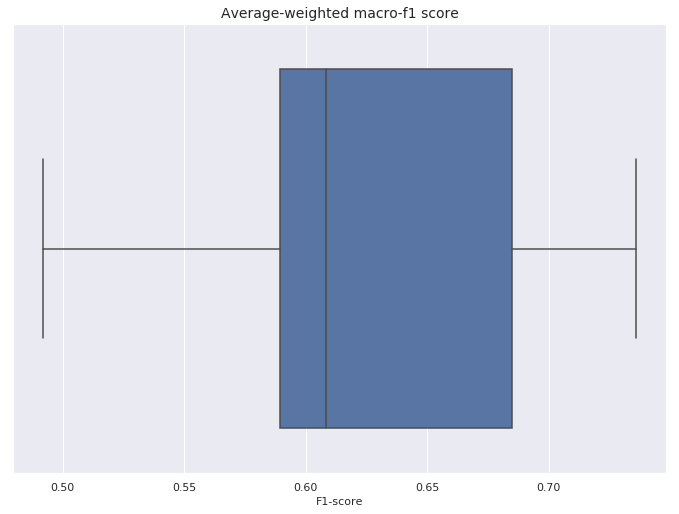

In [35]:
plot = sns.boxplot(macro_f1_scores)
plot.set_title('Average-weighted macro-f1 score', fontdict={'fontsize': 14})
plot.set_xlabel("F1-score", fontdict={'fontsize': 11})

if save_plots == True:
    fig = plot.get_figure()
    fig.savefig('output/macro_f1_scores.png')

In [ ]:
pd.Series(pd.Series(macro_f1_scores).median()).to_csv('output/median_macro_f1.csv')

### Boxplot showing accuracy scores

In [ ]:
sns.boxplot(accuracy_scores)

### Get feature importances

In [ ]:
feat_imp_df = pd.DataFrame(data = feat_imp_dict)
feat_imp_df.head()

In [ ]:
feat_imp_df_final = pd.concat([feat_imp_df, pd.Series(my_data[my_data.columns.values[9:-1]].columns.values)], axis = 1)
feat_imp_df_final.rename(columns = {0:'element'}, inplace = True )
feat_imp_df_final.head()

In [ ]:
feat_imp_df_final.set_index('element', inplace=True)


In [ ]:
feat_imp_df_final_plot = feat_imp_df_final.T

In [ ]:
feat_imp_df_final_plot

elements = feat_imp_df_final_plot.columns.values 
mean_feature_importance = []
for col in list(feat_imp_df_final_plot.columns.values):
    mean_feature_importance.append(feat_imp_df_final_plot[col].mean())
    

In [ ]:
mean_feature_importance_df = pd.concat([pd.Series(elements), pd.Series(mean_feature_importance)], axis = 1)

In [ ]:
mean_feature_importance_df.rename(columns={0:'elements', 1:'mean_importance'}, inplace=True)

In [ ]:
mean_feature_importance_df.sort_values(by='mean_importance', ascending=False, inplace=True)

In [ ]:
ordered_col_names = list(mean_feature_importance_df['elements'])

In [ ]:
sns.set_style("whitegrid")
sns.set_style()
sns.set(rc={'figure.figsize':(20,20)})
plot = sns.boxplot(data = feat_imp_df_final_plot[ordered_col_names])
plot.set_xticklabels(plot.get_xticklabels(),rotation=90, ha = 'left')
plot.set_title('Feature (element) importance', fontdict={'fontsize': 20})
plot.set_ylabel('Feature importance', fontdict={'fontsize': 15})
plot.set_xlabel("Element", fontdict={'fontsize': 15})

if save_plots == True:
    fig = plot.get_figure()
    fig.savefig('output/feature_importances.png')

### Model is built for predicting source of artefacts 

In [ ]:
RFC_final = RandomForestClassifier(n_estimators=2000, random_state = random_seed_state)

In [ ]:
RFC_final.fit(X, y)

In [ ]:
if pickle_model == True:
    pickle.dump(RFC_final, open('models/' + pickle_model_name + '_' + 'rfc_model.sav', 'wb'))

In [ ]:
print(train_data_formodel['class'].unique())
print(uniques)

In [ ]:
df_for_identifiers = test_data.copy(deep = True)
identifiers =  df_for_identifiers['Analysis']

### Predictions are made for the artefacts

In [ ]:
y_pred = RFC_final.predict(np.array(test_data[test_data.columns.values[9:-1]]))

y_pred_proba = RFC_final.predict_proba(np.array(test_data[test_data.columns.values[9:-1]]))


In [ ]:
probabilities_df = pd.DataFrame(data = y_pred_proba, columns = uniques)
probabilities_df_final = pd.concat([probabilities_df, pd.Series(list(identifiers))], axis = 1)

In [ ]:
probabilities_df_final.rename(columns = {0:'identifier'}, inplace=True)

In [ ]:
final_pred_df = pd.concat([pd.Series(y_pred), probabilities_df_final], axis = 1)

In [ ]:
final_pred_df.rename(columns={0:'class_number'}, inplace = True)

In [ ]:
final_pred_df.to_csv('output/predictions.csv')


In [ ]:
uniques_list = list(uniques)
def get_pred_names(row):
    return(uniques_list[row['class_number']])
final_pred_df['class_predictions'] = final_pred_df.apply(get_pred_names, axis = 1)

In [ ]:
#final_pred_df_modal = final_pred_df.groupby(by = 'class_number')

In [ ]:
final_pred_df.head()